In [1]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import mltools as ml
import time

np.random.seed(0)
%matplotlib inline

## Differences Between Linear Classifier and Linear Regression
We start with loading a data that was created for this discussion and talk a about the differences between linear regression and linear classifier.

In [2]:
lc2_data = np.genfromtxt('./lc2_data.txt', delimiter=None)
X, Y = lc2_data[:, :-1], lc2_data[:, -1]

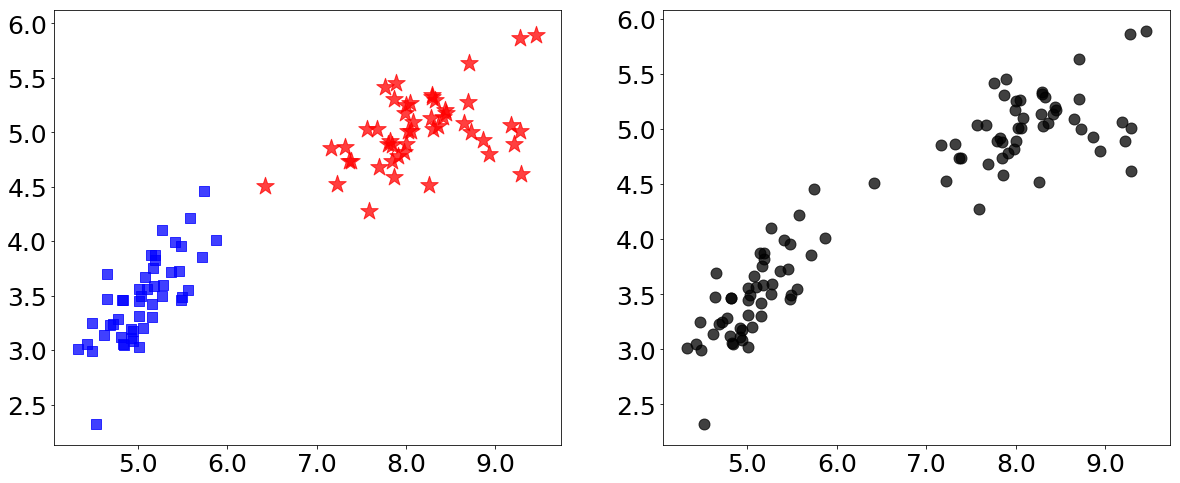

In [3]:
f, ax = plt.subplots(1, 2, figsize=(20, 8))

mask = Y == -1

ax[0].scatter(X[mask, 0], X[mask, 1], s=120, color='blue', marker='s', alpha=0.75)
ax[0].scatter(X[~mask, 0], X[~mask, 1], s=340, color='red', marker='*', alpha=0.75)

ax[0].set_xticklabels(ax[0].get_xticks(), fontsize=25)
ax[0].set_yticklabels(ax[0].get_yticks(), fontsize=25)

ax[1].scatter(X[:, 0], X[:, 1], s=120, color='black', alpha=0.75)

ax[1].set_xticklabels(ax[1].get_xticks(), fontsize=25)
ax[1].set_yticklabels(ax[1].get_yticks(), fontsize=25)

plt.show()

Some questions to think about. Make sure you know how to answer all of them :)

1. If it's a linear classifier, and the blue and red are the differenc classes, how many features do we have here?
3. How would a classifier line will look like if I plot it here?
3. Give me a real life example.
2. If it's a linear regression and you can ignore the colors, how many features are here?
4. And a regression line? (The simple f(x) = ax + c one)
5. Give me a real life example.
8. Can I treat this problem as a regression if I tell you that the Y value is now 0 if it's blue and 1 if red?
9. How many features do we have now? 
10. How would the regression line look like?
11. Give me a real life example.

5. My task if to answer 'See this new point? Should it be red or blue?' -- which one do I need?
6. My task is now to answer 'what will be the value of a new point at 8.3?' -- which one do I need now?
7. How about 'I know the value of 'Y' is 4.7, what was the value of X?'
12. So how would a test data look like for the classification problem?
13. And how would it look like for the regression problem?

# Building a Classifier from the Ground Up
In the rest of the discussion we will show how to code a classifier from the ground up. This will be extremely useful not only for your homework assignment but also for future reference, as implementations of machine learning algorithms use similar tools and conventions.

## Perceptron Algorithm
As a simple example we will use the [Perceptron Algorithm](https://en.wikipedia.org/wiki/Perceptron). We will build each part seperately, showing how it works and end by wrapping it all up in a classifier class that can be used with the mltools library. 

We will use a 2 classes Perceptron with classes $\{-1, 1\}$. In the discussion you can also see how to use a binary classes $\{0, 1\}$ and in the wiki [page](https://en.wikipedia.org/wiki/Perceptron) you can see a generalization to multiple classes.

For an illustration of the algorithm you can watch this YouTube [clip](https://www.youtube.com/watch?v=vGwemZhPlsA)

### Decision Boundry and Classification
The Perceptron uses a decidion boundary $\theta$ to compute a value for each point. Taking the sign of this value will then give us a class prediction.

We'll start by computing the decision value for each point $x^j$: $$\theta x^j$$

As an example, let's choose $j=90$ (the 90th observation in our dataset) and let's define: $$\theta = \left[-6, 0.5, 1\right]$$

In [4]:
theta = np.array([-6., 0.5, 1.])

Notice the '.'s. This will make sure it's a float and not integer which can casue problems later down the line.

$\theta$ has three features that correspond to the constant (also known as the 'bias' or 'intercept') and the two features of X. To account for the constant term, we will add constant 1 to each observation in X. 

Do not use the fpoly to do this, the behavior of that function is unexpected when there is more than one feature.

In [5]:
def add_const(X):
    return np.hstack([np.ones([X.shape[0], 1]), X])

Xconst = add_const(X)
x_j, y_j = Xconst[90], Y[90]

### Response Value
The first step in the preceptron is to compute the response value. It's comptued as the inner (dot) product $\theta x^j$. The simple intuative way to do that is to use a for loop. 

In [6]:
x_theta = 0
for i in range(x_j.shape[0]):
    x_theta += x_j[i] * theta[i]
    
print x_theta

3.346025


This is a VERY inefficient way to do compute a inner product. Luckily for us, numpy has the answer in the form of np.dot().

In [7]:
print np.dot(x_j, theta)

3.346025


### Classification Decision
Now let's compute the decision classification $T[\theta x^j]$. One option is to use the [np.sign](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.sign.html) method. This is not a a good solution because np.sign(0) = 0.

One solution is to check for 0s explicitly.

In [24]:
def sign(vals):
    """Returns 1 if val >= 0 else -1"""
    s = np.sign(vals)
    try: # If vals is an array
        s[s == 0] = 1
    except: # If vals is a float
        s = 1 if s == 0 else s
    return s

### Predict function
So now with the the decision value and my_sign we can write the predict function

In [9]:
def predict(x_j, theta):
    """Returns the class prediction of a single point x_j"""
    return sign(np.dot(x_j, theta))

In [10]:
print predict(x_j, theta)

1.0


### Computing the Prediction Error
Using the predict function, we can now compute the prediction error: $$J^j = (y^j - \hat{y}^j)$$

In [12]:
def pred_err(X, Y, theta):
    """Predicts that class for X and returns the error rate. """
    Yhat = predict(X, theta)
    return np.mean(Yhat != Y)

In [13]:
print pred_err(x_j, y_j, theta)

0.0


### Learning Update
Using the error we can now even do the update step in the learning algorithm: $$\theta = \theta + \alpha * (y^j - \hat{y}^j)x^j$$

In [14]:
a = 0.1
y_hat_j = predict(x_j, theta)
print theta + a * (y_j - y_hat_j) * x_j

[-6.   0.5  1. ]


### Train method
Using everything we coded so far, we can fully create the train method

In [15]:
def train(X, Y, a=0.01, stop_tol=1e-8, max_iter=1000):
    # Start by adding a const
    Xconst = add_const(X)
    
    m, n = Xconst.shape
    
    # Initializing theta
    theta = np.array([-6., 0.5, 1.])
    
    # The update loops
    J_err = [np.inf]
    
    for i in range(1, max_iter + 1):             # Pass through the dataset max_iter times
        
        for j in range(m):                       # Loop through each observation
            x_j, y_j = Xconst[j], Y[j]           # Get observation j
            y_hat_j = predict(x_j, theta)        # Predict using the current theta
            theta += a * (y_j - y_hat_j) * x_j   # Update theta

        # Compute the error on the dataset after each pass
        curr_err = pred_err(Xconst, Y, theta)
        J_err.append(curr_err)

        # Stop if the change in error is small
        if np.abs(J_err[-2] - J_err[-1]) < stop_tol:
            print 'Reached convergance after %d iterations. Prediction error is: %.3f' % (i, J_err[-1])
            break
        
    return theta

In [16]:
theta_trained = train(X, Y)

Reached convergance after 3 iterations. Prediction error is: 0.071


## Creating a Perceptron Classifier
Now let's use all the code that we wrote and create a Python class Perceptron that can plug in to the mltools package.

In order to do that, the Prceptron class has to inherit the object mltools.base.classifier

In case you haven't looked at the actual code in the mltools, now will probably be the right time.

In [17]:
from mltools.base import classifier

In order to crete an object, we'll have to add self to all the methods.

In [21]:
class Perceptron(classifier):
    def __init__(self, theta=None):
        self.theta = theta
    
    def predict(self, X):
        """Retruns class prediction for either single point or multiple points. """
        # I'm addiing this stuff here so it could work with the plotClassify2D method.
        Xconst = np.atleast_2d(X)
        
        # Making sure it has the const, if not adding it.
        if Xconst.shape[1] == self.theta.shape[0] - 1:
            Xconst = add_const(Xconst)
        
        return self.sign(np.dot(Xconst, self.theta))
                
    def sign(self, vals):
        """A sign version with breaking 0's as +1. """
        return np.sign(vals + 1e-200)
    
    def pred_err(self, X, Y):
        Yhat = self.predict(X)
        return np.mean(Yhat != Y)
    
    def train(self, X, Y, a=0.02, stop_tol=1e-8, max_iter=1000):
        # Start by adding a const
        Xconst = add_const(X)

        m, n = Xconst.shape
        
        # Making sure Theta is inititialized.
        if self.theta is None:
            self.theta = np.random.random(n)

        # The update loops
        J_err = [np.inf]
        for i in range(1, max_iter + 1):
            for j in range(m):
                x_j, y_j = Xconst[j], Y[j]
                y_hat_j = self.predict(x_j)
                self.theta += a * (y_j - y_hat_j) * x_j
                
            curr_err = self.pred_err(Xconst, Y)
            J_err.append(curr_err)

            if np.abs(J_err[-2] - J_err[-1]) < stop_tol:
                print 'Reached convergance after %d iterations. Prediction error is: %.3f' % (i, J_err[-1])
                break

### Creating a model, training and plotting predictions

First let's create the model with some initialized theta and plot the decision bounderies. For the plotting we can use the mltools plotClassify2D !!! wowowowo!!!!

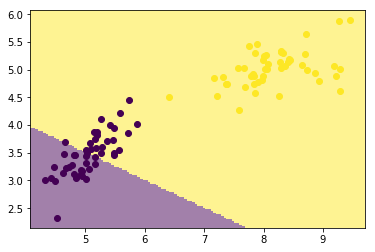

In [22]:
model = Perceptron()
model.theta = np.array([-6., 0.5, 1])

ml.plotClassify2D(model, X, Y)
plt.show()

Next, let's actually train the model and plot the new decision boundery.

Reached convergance after 36 iterations. Prediction error is: 0.000


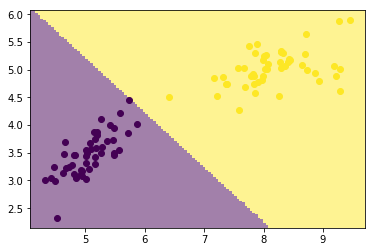

In [23]:
model.theta = np.array([-6., 0.5, 1])
model.train(X, Y)
ml.plotClassify2D(model, X, Y)

We found the best classifier!!!